In [1]:
### ### ### IMPORTS ### ### ### 
import os
from fredapi import Fred # https://github.com/mortada/fredapi
import pandas as pd
import timeit
from datetime import datetime, date
import time
import scipy.stats as stats
from scipy.stats import gmean
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
date = date.today()

In [2]:
### ### ### API AUTHENTICATION USING ENVIRONMENTAL VARIABLES ### ### ### 
FRED_API = os.environ['FRED_API']
api = Fred(api_key=FRED_API)

In [3]:
### ### ### LOG TIME SCRIPT BEGINS ### ### ### 
start = datetime.now()
print('*****   *****   SCRIPT STARTING   *****   *****')
print('SCRIPT STARTED AT: ',start)

*****   *****   SCRIPT STARTING   *****   *****
SCRIPT STARTED AT:  2023-01-10 23:00:45.759800


In [4]:
### ### ### GRAB FRED DATA SERIES ### ### ### 
# The API will return a series, but we define it as one anyway so we can pass a name to be used in df concatenation afterward

# Inputs for Tobin's Q / VM Index
net_worth = pd.Series(api.get_series('TNWMVBSNNCB'),name='net_worth') # nonfinancial networth
market_cap = pd.Series(api.get_series('WILL5000PRFC'),name='market_cap') # wilshire 5000 price cap
corp_debt_pct = pd.Series(api.get_series('NCBCMDPMVCE'),name='corp_debt_pct') # nonfinancial corporate debt % of market value of corp equities

time.sleep(3)
# Inputs for net liquidity measure
frb_total_assets = pd.Series(api.get_series('WALCL'),name='frb_ta') # asset side of FRB balance sheet
on_rrp = pd.Series(api.get_series('RRPONTSYD'),name='on_rrp') # overnight reverse repo notional
trsy_general_account = pd.Series(api.get_series('WTREGEN'),name='tsy_ga') # treasury general account
corp_profits = pd.Series(api.get_series('CP'),name='corp_profits') #corp profits without inventory value or capital consumption adjustments
corp_profits_adj = pd.Series(api.get_series('CPATAX'),name='corp_profits_adj') #corp profits with inventory value or capital consumption adjustments
time.sleep(3)
# Inputs for yield curve

'''sofr = pd.Series(api.get_series('SOFR'),name='SOFR') # Secured Overnight Funding Rate
sofr_v = pd.Series(api.get_series('SOFRVOL'),name='SOFR_V') # Secured Overnight Funding Rate
effr = pd.Series(api.get_series('EFFR'),name='EFFR') # Effective Federal Funds Rate
effr_v = pd.Series(api.get_series('EFFRVOL'),name='EFFR_V') # Effective Federal Funds Rate
tffr_ul = pd.Series(api.get_series('DFEDTARU'),name='TFRR_UL') # Target Fed Funds Rate, Upper Limit
tfrr_ll = pd.Series(api.get_series('DFEDTARL'),name='TFRR_LL') # Target Fed Funds Rate, Lower Limit

time.sleep(3)
thee_mo = pd.Series(api.get_series('DGS3MO'),name='3mo')
six_mo = pd.Series(api.get_series('DGS6MO'),name='6mo')
one_yr = pd.Series(api.get_series('DGS1'),name='1yr')
two_yr = pd.Series(api.get_series('DGS2'),name='2yr')
five_yr = pd.Series(api.get_series('DGS5'),name='5yr')
ten_yr = pd.Series(api.get_series('DGS10'),name='10yr')
twenty_yr = pd.Series(api.get_series('DGS20'),name='20yr')
thirty_yr = pd.Series(api.get_series('DGS30'),name='30yr')
ten_yr_TIPS = pd.Series(api.get_series('DFII10'),name='10yr_TIPS')

time.sleep(3)
# Inputs for inflation
ten_yr_BE = pd.Series(api.get_series('T10YIE'),name='10yr_BE') # 10 year break even rate; difference between 10 year and 10 year TIPS (what participants think inflation will be, on average, in 10 years)
CPI = pd.Series(api.get_series('CPIAUCSL'),name='CPI') # All city CPI
PPI = pd.Series(api.get_series('PPIACO'),name='PPI')
PCE = pd.Series(api.get_series('PCEPI'),name='PCE')
'''


"sofr = pd.Series(api.get_series('SOFR'),name='SOFR') # Secured Overnight Funding Rate\nsofr_v = pd.Series(api.get_series('SOFRVOL'),name='SOFR_V') # Secured Overnight Funding Rate\neffr = pd.Series(api.get_series('EFFR'),name='EFFR') # Effective Federal Funds Rate\neffr_v = pd.Series(api.get_series('EFFRVOL'),name='EFFR_V') # Effective Federal Funds Rate\ntffr_ul = pd.Series(api.get_series('DFEDTARU'),name='TFRR_UL') # Target Fed Funds Rate, Upper Limit\ntfrr_ll = pd.Series(api.get_series('DFEDTARL'),name='TFRR_LL') # Target Fed Funds Rate, Lower Limit\n\ntime.sleep(3)\nthee_mo = pd.Series(api.get_series('DGS3MO'),name='3mo')\nsix_mo = pd.Series(api.get_series('DGS6MO'),name='6mo')\none_yr = pd.Series(api.get_series('DGS1'),name='1yr')\ntwo_yr = pd.Series(api.get_series('DGS2'),name='2yr')\nfive_yr = pd.Series(api.get_series('DGS5'),name='5yr')\nten_yr = pd.Series(api.get_series('DGS10'),name='10yr')\ntwenty_yr = pd.Series(api.get_series('DGS20'),name='20yr')\nthirty_yr = pd.Series(ap

In [5]:
import yfinance as yf
# This will download data from yahoo finance - more than enough for prototyping
spy_df = yf.download(
        # tickers list or string as well
        tickers = "^GSPC",
        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "max",
        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",
        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',
        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,
        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,
        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = False,
        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

[*********************100%***********************]  1 of 1 completed


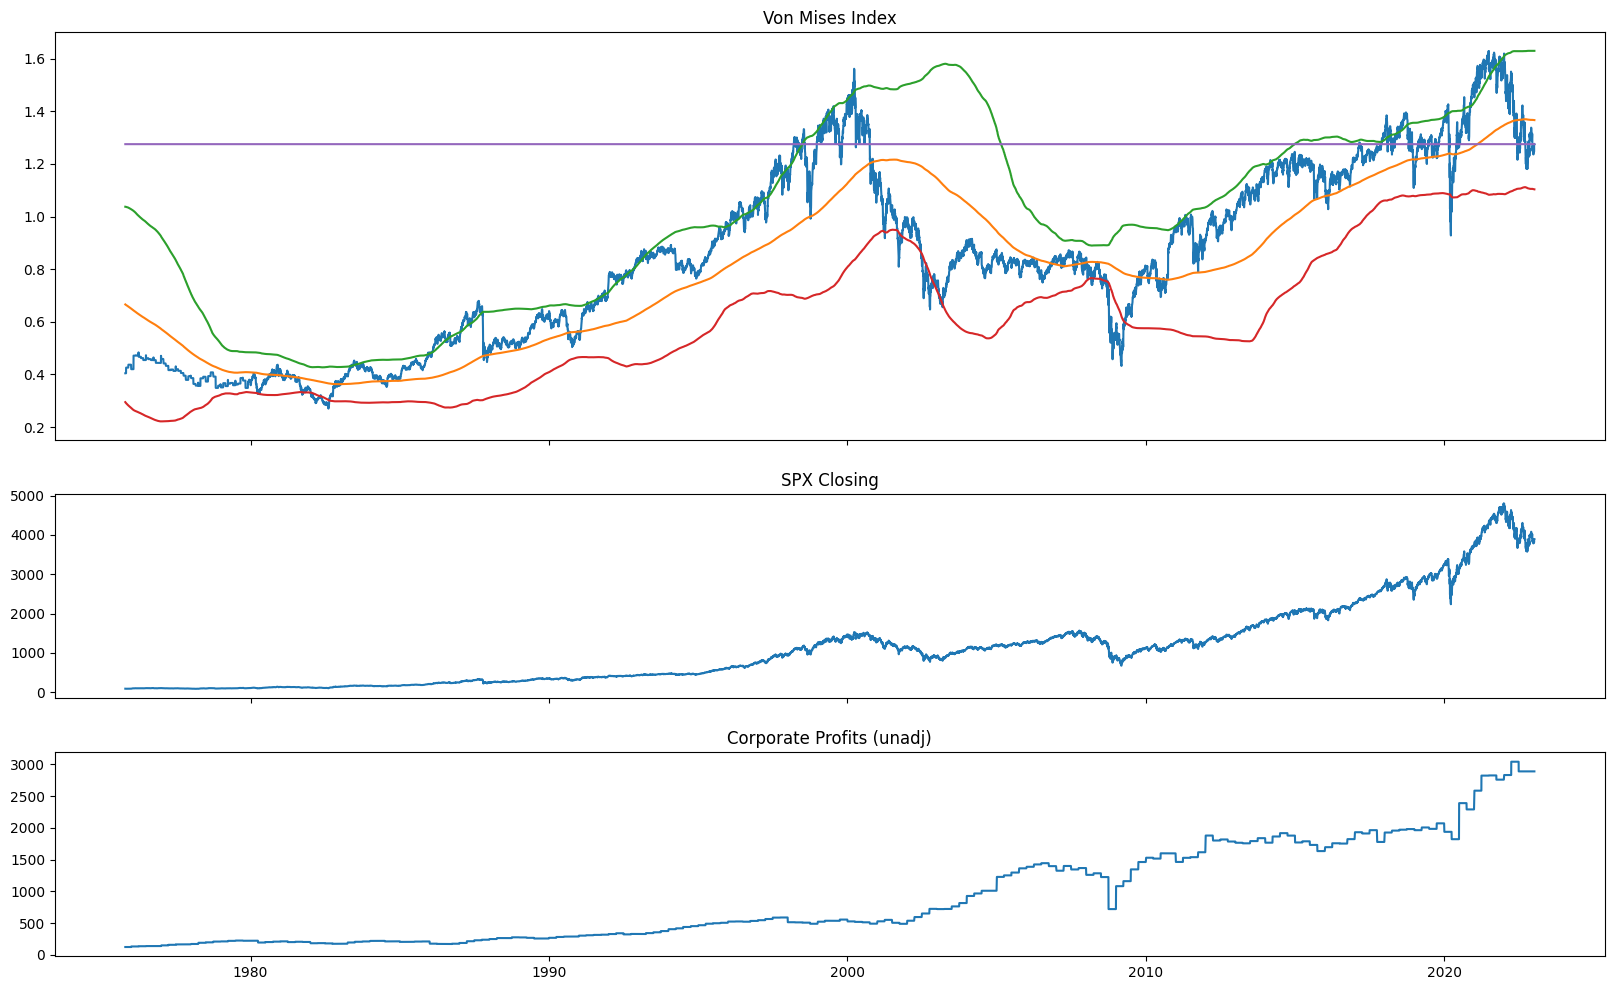

In [6]:
lookback_years = 5
lookback = 252 * lookback_years

### ### ### MERGE INTO SINGLE DATAFRAME ### ### ###
df = pd.concat([net_worth,market_cap,corp_debt_pct,corp_profits],axis=1)
df = df.fillna(method='ffill') #we fill forward because the net worth data only comes in quarterly, therefore we'll retain the last reported figure for each of the daily market cap records
df.dropna(inplace=True)
df['corp_debt'] = df['market_cap'] * (df['corp_debt_pct']/100)
df['ev'] = df['corp_debt'] + df['market_cap']
df['q_ev'] = (df['ev'])/df['net_worth']
df['q_ev_ma'] = df['q_ev'].rolling(lookback).mean()
df['q_mc'] = df['market_cap']/df['net_worth']
df['q_mc_ma'] = df['q_mc'].rolling(lookback).mean()
df['q_mc_sd'] = df['q_mc'].rolling(lookback).std()
df['q_mc_sd2up'] = df['q_mc_ma'] + (2 * df['q_mc_sd'])
df['q_mc_sd2down'] = df['q_mc_ma'] - (2 * df['q_mc_sd'])
df['q_spread'] = df['q_ev'] - df['q_mc']
df['lastprint'] = df['q_mc'][-1]
df = pd.concat([df,spy_df],axis=1)
df.dropna(inplace=True)
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True, figsize=(20,12),gridspec_kw={'height_ratios': [2, 1, 1]})
ax1.plot(df[['q_mc','q_mc_ma','q_mc_sd2up', 'q_mc_sd2down','lastprint']])
ax1.set_title('Von Mises Index')
ax2.plot(df['Close'])
ax2.set_title("SPX Closing")
ax3.plot(df['corp_profits'])
ax3.set_title('Corporate Profits (unadj)')
filename = 'Equities Valuation_'+date.strftime("%Y_%m_%d")+'.png'
plt.savefig(filename)

In [7]:
df['q_mc_zscore'] = stats.zscore(df['q_mc'])
print("Last VMI Print:",np.round(df['q_mc'][-1],decimals=4))
print("Current VMI Print's Percentile:", np.round(stats.norm.cdf(df['q_mc_zscore'][-1]),decimals=4))

Last VMI Print: 1.275
Current VMI Print's Percentile: 0.9008


In [8]:
recent = df.q_mc[-lookback:]
recent = stats.zscore(recent)
recent[-1]
print("Percentile Adjusted for",lookback_years,"Year Lookback:",np.round(stats.norm.cdf(recent[-1]),decimals=4))

Percentile Adjusted for 5 Year Lookback: 0.2432


<AxesSubplot: >

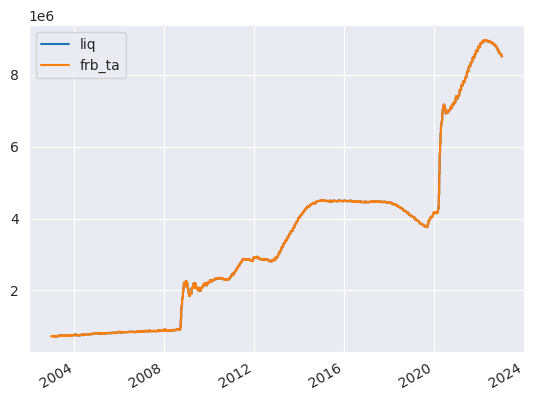

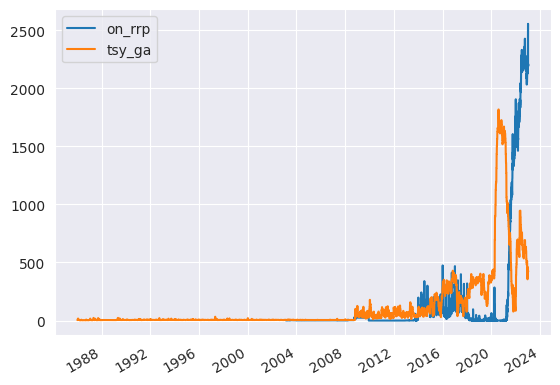

In [62]:
### ### ### MERGE INTO SINGLE DATAFRAME ### ### ###
df = pd.concat([frb_total_assets, on_rrp, trsy_general_account],axis=1)
df = df.fillna(method='ffill') #we fill forward because the net worth data only comes in quarterly, therefore we'll retain the last reported figure for each of the daily market cap records
df['liq'] = df['frb_ta']-(df['on_rrp']+df['tsy_ga'])
df['liq_ma'] = df['liq'].rolling(lookback).mean()
df[['liq','frb_ta']].plot()
df[['on_rrp','tsy_ga']].plot()
#df

,EFFR,SOFR,spread
2018-04-03,1.69,1.83,-0.14
2018-04-04,1.69,1.74,-0.05
2018-04-05,1.69,1.75,-0.06
2018-04-06,1.69,1.75,-0.06
2018-04-09,1.69,1.75,-0.06
...,...,...,...
2023-01-03,4.33,4.31,0.02
2023-01-04,4.33,4.30,0.03
2023-01-05,4.33,4.31,0.02
2023-01-06,4.33,4.31,0.02


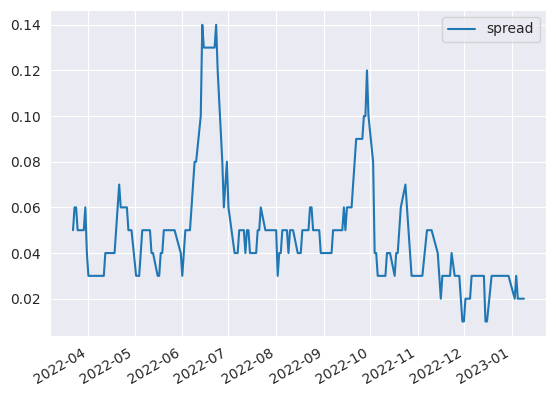

In [39]:
df = pd.concat([effr, sofr],axis=1)
#df = df.fillna(method='ffill')
df['spread'] = df.EFFR - df.SOFR
df.dropna(inplace=True)
df[-200:][['spread']].plot()
df

In [8]:
'''### ### ### CHANGE TO OUR STORAGE LOCATION ### ### ###
print('Old Working Directory:',os.getcwd())
os.chdir('/media/Data2/Alpha Hound/Equity Algo/FRED API')
print('New Working Directory:',os.getcwd())'''

"### ### ### CHANGE TO OUR STORAGE LOCATION ### ### ### \nprint('Old Working Directory:',os.getcwd())\nos.chdir('/media/Data2/Alpha Hound/Equity Algo/FRED API')\nprint('New Working Directory:',os.getcwd())"

In [9]:
'''df.to_csv('Q_Index.csv')'''

"df.to_csv('Q_Index.csv')"

In [10]:
### ### ### LOG SCRIPT END TIME ### ### ###
end = datetime.now()
print('*****   *****   SCRIPT FINISHED   *****   *****')
print('FINISHED AT: ',end)

*****   *****   SCRIPT FINISHED   *****   *****
FINISHED AT:  2022-10-02 17:14:05.939702


In [7]:
df = pd.concat([df,spy_df],axis=1)

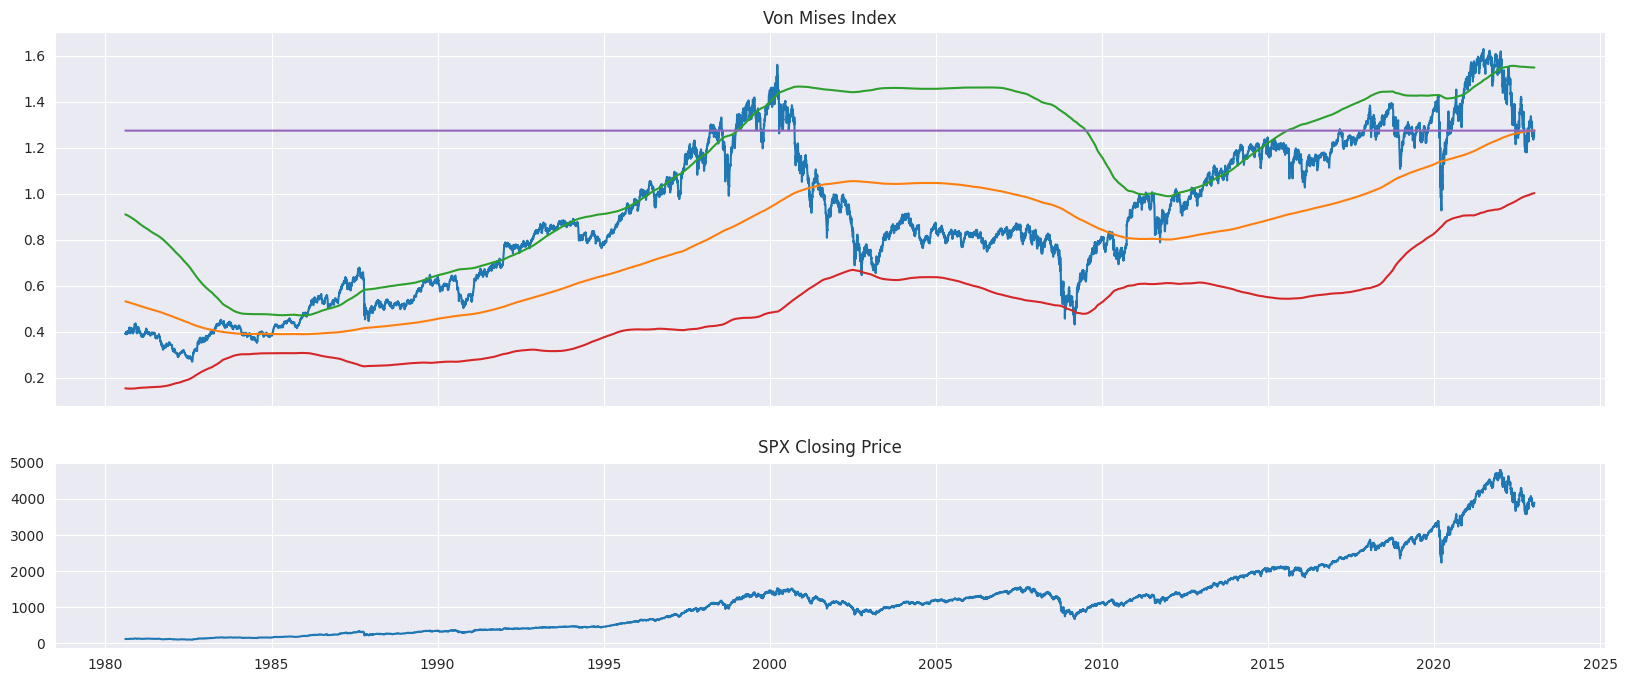

In [14]:
df.dropna(inplace=True)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(20,8),gridspec_kw={'height_ratios': [2, 1]})
ax1.plot(df[['q_mc','q_mc_ma','q_mc_sd2up', 'q_mc_sd2down','lastprint']])
ax1.set_title('Von Mises Index')
ax2.plot(df['Close'])
ax2.set_title('SPX Closing Price')
plt.savefig('test.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

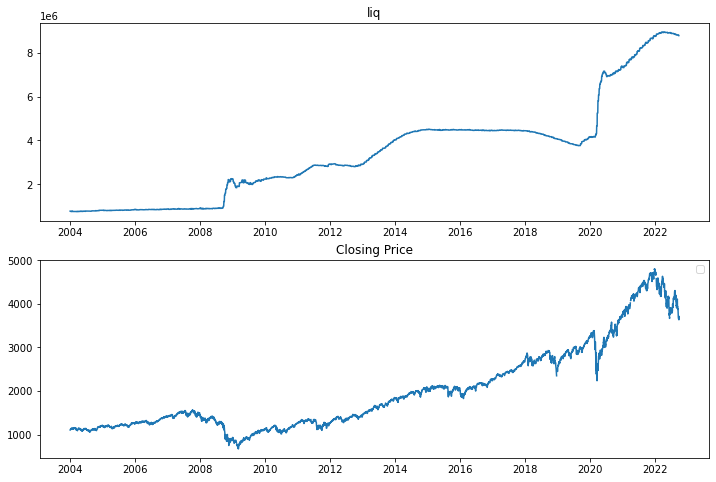

In [13]:
fig, ax = plt.subplots(figsize=(12,8))

exam_start = '2004-01-01'
exam_end = '2022-09-29'

plt.subplot(211)
plt.plot(df[exam_start:exam_end].liq)
plt.title(label="liq")


plt.subplot(212)
plt.plot(df[exam_start:exam_end].Close)
plt.title("Closing Price")
plt.legend()
plt.tight_layout

In [14]:
df

,frb_ta,on_rrp,tsy_ga,liq,liq_ma,Open,High,Low,Close,Volume
1950-01-03,NaN,NaN,NaN,NaN,NaN,16.660000,16.660000,16.660000,16.660000,1.260000e+06
1950-01-04,NaN,NaN,NaN,NaN,NaN,16.850000,16.850000,16.850000,16.850000,1.890000e+06
1950-01-05,NaN,NaN,NaN,NaN,NaN,16.930000,16.930000,16.930000,16.930000,2.550000e+06
1950-01-06,NaN,NaN,NaN,NaN,NaN,16.980000,16.980000,16.980000,16.980000,2.010000e+06
1950-01-09,NaN,NaN,NaN,NaN,NaN,17.080000,17.080000,17.080000,17.080000,2.520000e+06
...,...,...,...,...,...,...,...,...,...,...
2022-09-26,8816802.0,2299.011,692.496,8813810.493,6.590174e+06,3682.719971,3715.669922,3644.760010,3655.040039,4.886140e+09
2022-09-27,8816802.0,2327.111,692.496,8813782.393,6.594882e+06,3686.439941,3717.530029,3623.290039,3647.290039,4.577740e+09
2022-09-28,8795567.0,2366.798,689.569,8792510.633,6.599578e+06,3651.939941,3736.739990,3640.610107,3719.040039,4.684850e+09
2022-09-29,8795567.0,2371.763,689.569,8792505.668,6.604273e+06,3687.010010,3687.010010,3610.399902,3640.469971,4.681810e+09
